In [19]:
# include controllers to the path
import sys, os
sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), 'controllers'))

import cv2
import threading
import math
import time
import random
import json
import datetime
import os, shutil
import numpy as np
import multiprocess as mp

# controllers
import nbimporter
from controllers.situtils import FPSTimes
from controllers.camera import WebcamStream
from controllers.video import VideoWriter
from controllers.position import PositionTracker
from controllers.sound import SoundController
from controllers.serial import MCSArduino, FakeArduino, Feeder
from postprocessing import pack

## Load experiment settings

For every experimental cofiguration you can copy the original 'settings.json' file, build your own specific experimental preset, save it in this folder as e.g. 'settings_elena.json' and load it here instead of 'settings.json'.

In [20]:
cfg_filename = os.path.join('profiles', 'dardo_aSIT_single.json')

In [21]:
with open(cfg_filename) as json_file:
    cfg = json.load(json_file)
cfg['experiment']['experiment_date'] = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# print loaded settings
#print(json.dumps(cfg, indent=4))

In [22]:
# check if the sound interface is there
import sounddevice as sd
asio = [x for x in sd.query_devices() if x['name'].find('ASIO') > 0]
#if len(asio) == 0:
#    raise SystemExit('The sound interface is not found. Please restart the computer')

## Initialize session folder

Run the upcoming cell, to create a session folder and to save the chosen experimetal parameters to a JSON-file ("experiment_id_parameters.json"). The session folder will be created here where this notebook is located.

In [23]:
# This session's protocols will be saved to this folder
cfg_exp = cfg['experiment']
experiment_id = "%s_%s_%s" % (cfg_exp['subject'], cfg_exp['experiment_type'], cfg_exp['experiment_date'])
save_to = os.path.join('sessions', experiment_id)
             
if not os.path.exists(save_to):
    os.makedirs(save_to)

# update paths (assuming this paths are relative to this notebook)
cfg['video']['file_path'] = os.path.join(save_to, 'video.avi')
cfg['position']['file_path'] = os.path.join(save_to, 'positions.csv')
cfg['experiment']['file_path'] = os.path.join(save_to, 'events.csv')
cfg['sound']['file_path'] = os.path.join(save_to, 'sounds.csv')
cfg['position']['background_light'] = os.path.join('assets', cfg['position']['background_light'])
cfg['position']['background_dark'] = os.path.join('assets', cfg['position']['background_dark'])
    
# Saves all parameters to a JSON file with the user-defined "Experiment ID" as filename
with open(os.path.join(save_to, experiment_id + '.json'), 'w') as f:
    json.dump(cfg, f, indent=4)
    
with open(cfg['experiment']['file_path'], 'w') as f:
    # state: 0 - trial start, 1 - trial success, 2 - trial fail
    f.write('time, target_x, target_y, target_r, trial, state\n')

In [24]:
class Island:    
    def __init__(self, x, y, radius, sound_id, is_distractor=False):
        self.x = x  # in meters
        self.y = y  # in meters
        self.r = radius  # in meters
        self.sound_id = sound_id
        self.is_distractor = is_distractor

In [1]:
def generate_islands(floor_radius, island_radius, distractors=0):
    def get_new_xy(islands=[]):
        while True:
            # all in meters
            rho = np.sqrt(np.random.rand()) * (floor_radius - island_radius)
            phi = np.random.rand() * 2 * np.pi
            x = rho * np.sin(phi)
            y = rho * np.sin(phi)

            for island in islands:
                if (island.x - x)**2 - (island.y - y)**2 < (2*island_radius)**2:
                    continue
                    
            return x, y
    
    # target island
    x, y = get_new_xy()
    islands = [Island(x, y, island_radius, 2)]  # sound 2 is always target
    
    if len(distractors) > 0:
        for i in range(distractors):
            x, y = get_new_xy(islands)
            islands.append(Island(x, y, island_radius, i + 3))
    
    return islands  # always a list of Islands

In [26]:
def timeout(t_start):
    return time.time() - t_start > cfg_exp['session_duration'] if t_start is not None else False

In [27]:
def log_event(*args):  # log start / end of a trial
    with open(cfg_exp['file_path'], 'a') as f:
        f.write(",".join([str(x) for x in args]) + "\n")

In [28]:
def switch_light(pt, board):
    pt.switch_background()
    board.switch_light()

## Start the experiment

This cell contains code for animal tracking. We hope that the comments provided in the code suffice to understand the individual steps and to adjust them to your own setup and needs, if necessary.

- press 's' to start recording
- press 's' again to stop recording
- press 'q' to quit

The experiment will stop automatically if the pre-defined session duration is reached.

In [30]:
x, y = contour[0][0][0], contour[0][0][1]
pt.px_to_meters(x, y), len(contour)

((-0.02564459930313589, -0.19874564459930313), 264)

In [31]:
ctr_in_m = np.array([pt.px_to_meters(x, y) for x, y in zip(contour[:, 0, 0], contour[:, 0, 1])])

In [32]:
ctr_in_px = np.array([x for x in zip(contour[:, 0, 0], contour[:, 0, 1])])

In [29]:
# actual sound selector: 0 - silence, 1 - foraging, 2 - target, 3 - distractor
sound = mp.Value('i', 1)

# experiment status: 1 - idle, 2 - running (recording, logging), 0 - stopped
status = mp.Value('i', 1)

# init the sync with the acquisition system via Arduino
if cfg['experiment']['MCSArduinoPort'] == 'fake':
    board = FakeArduino()
else:
    board = MCSArduino(cfg['experiment']['MCSArduinoPort'])

# init the feeder
feeder = Feeder(cfg['experiment']['feeder_port'])
    
# start the camera stream
vs = WebcamStream(cfg['camera'])
vs.start()

# init video recorder
vw = VideoWriter(status, vs, cfg['video'])
vw.start()

# start position tracking
pt = PositionTracker(status, vs, cfg['position'])
pt.start()

# playing sound in a separate process for performance
sc = mp.Process(target=SoundController.run, args=(sound, status, cfg['sound']))
sc.start()

timers = []
fps = FPSTimes()
names = ['camera', 'video', 'position', 'main']
trial = 0
rewards = 0
t_start = None
target_since = None
punishment_since = None
trial_start = time.time()
phase = 0  # 0 - idle, 1 - foraging, 2 - inter-trial interval
cfg_exp = cfg['experiment']
cfg_pos = cfg['position']
COLORS = {
    'red': (0,0,255), 'green': (127,255,0), 'blue': (255,127,0), 'yellow': (0,127,255), \
    'black': (0,0,0), 'white': (255,255,255)
}
islands = []
contour = None

try:
    while trial <= cfg_exp['trial_number'] and not timeout(t_start):
        frame = vs.read()
        if frame is None:
            time.sleep(0.1)
            continue # wait for the stream
            
        c_time = time.time()
        fps.count()
        status_color = COLORS['green'] if status.value == 1 else COLORS['red']

        # -------- prepare the video frame ---------------
        
        # mask space outside arena
        frame = cv2.bitwise_and(src1=frame, src2=pt.mask)
        #frame = cv2.subtract(frame, pt.background)
        #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # draw position center and contours
        if pt.x_in_px is not None:
            cv2.circle(frame, (pt.x_in_px, pt.y_in_px), 7, status_color, -1)
            cv2.drawContours(frame, [pt.contour], 0, status_color, 1, cv2.LINE_AA)  
            
            contour = pt.contour

        #l_s_x = cfg_pos['arena_x'] + cfg_pos['arena_radius'] - 20
        #l_e_x = cfg_pos['arena_x'] + cfg_pos['arena_radius'] + 20
        #cv2.line(frame, (l_s_x, cfg_pos['arena_y']), (l_e_x, cfg_pos['arena_y']), status_color, 5)
            
        # add FPS indicators
        for i, ctrl in enumerate([vs, vw, pt, fps]):
            cv2.putText(frame, '%s: %.2f FPS' % (names[i], ctrl.get_avg_fps()), 
                     (10, 30 + 20*(i+1)), cv2.FONT_HERSHEY_DUPLEX, .5, COLORS['white'])

        # size of the arena and status indicator
        cv2.circle(frame, (cfg_pos['arena_x'], cfg_pos['arena_y']), cfg_pos['arena_radius'], COLORS['red'], 2)
        cv2.circle(frame, (cfg_pos['arena_x'], cfg_pos['arena_y']), cfg_pos['floor_radius'], COLORS['red'], 2)
        cv2.circle(frame, (20,20), 10, status_color, -6)

        # draw islands
        if len(islands) > 0:
            for island in islands:
                clr = COLORS['red'] if island.is_distractor else COLORS['green']
                x, y = pt.meters_to_px(island.x, island.y)
                cv2.circle(frame, (x, y), int(island.r/pt.pixel_size), clr, 2)

        # positions of animal and target
        if pt.x_in_px is not None:
            cv2.putText(frame, 'Animal: %.3f %.3f' % (pt.x_in_m, pt.y_in_m), (10, 550), \
                        cv2.FONT_HERSHEY_DUPLEX, .5, COLORS['white'])
            cv2.putText(frame, '%.2f %.2f' % (pt.x_in_m, pt.y_in_m), (pt.x_in_px + 10, pt.y_in_px + 10), \
                        cv2.FONT_HERSHEY_DUPLEX, .3, COLORS['white'])
            
        if len(islands) > 0:
            target = [i for i in islands if not i.is_distractor][0]
            cv2.putText(frame, 'Target: %.3f %.3f' % (target.x, target.y), (10, 570), \
                        cv2.FONT_HERSHEY_DUPLEX, .5, COLORS['white'])
            
        # stopwatch
        stopwatch = 'Time: %.2f' % float(c_time - t_start) if t_start is not None else 'Time: Idle'
        cv2.putText(frame, stopwatch, (10, 590), cv2.FONT_HERSHEY_DUPLEX, .5, COLORS['white'])

        # trial countdown (TODO add island countdown)
        if status.value > 1:
            text = 'Trial: %.2f' % float(cfg_exp['trial_duration'] - (c_time - trial_start))
            cv2.putText(frame, text, (10, 610), cv2.FONT_HERSHEY_DUPLEX, .5, COLORS['white'])
            cv2.putText(frame, 'Trial: %s' % trial, (10, 630), cv2.FONT_HERSHEY_DUPLEX, .5, COLORS['white'])
            
        # rewards
        cv2.putText(frame, 'Rewards: %s' % rewards, (10, 650), cv2.FONT_HERSHEY_DUPLEX, .5, COLORS['white'])
        
        # time since in target
        if target_since is not None:
            cv2.putText(frame, 'In target: %.2f' % float(c_time - target_since), (10, 670), cv2.FONT_HERSHEY_DUPLEX, .5, COLORS['white'])
        
        # Light or dark period
        cv2.putText(frame, 'Light' if pt.is_light else 'Dark', (10, 690), cv2.FONT_HERSHEY_DUPLEX, .5, (255, 255, 255))            
        
        # assign the frame back to the video stream for other controllers
        vs.frame_with_infos = frame
        
        cv2.imshow('Press (s)-to start/stop, (q)-to end', frame)

        # -------- experiment logic ---------------
        
        # animals is either foraging (phase == 1) or in the inter-trial-interval (phase == 2)
        if phase == 1: # foraging
            if pt.x_in_m is not None and len(islands) > 0:
                # check if animal in the island and for how long
                tgt = [i for i in islands if not i.is_distractor][0]
                distractors = [i for i in islands if i.is_distractor]
                
                if (pt.x_in_m - tgt.x)**2 + (pt.y_in_m - tgt.y)**2 <= cfg_exp['target_radius']**2:
                    if target_since is None:  # just entered target
                        target_since = c_time
                        sound.value = 2

                    elif c_time - target_since > cfg_exp['target_duration']: # successful trial
                        log_event(c_time, round(tgt.x, 4), round(tgt.y, 4), round(tgt.r, 4), trial, 1) # log trial success
                        feeder.feed()
                        
                        # init inter-trial interval and new trial
                        trial_start = c_time + 10 + 5 * np.random.rand()  # random b/w 10-15 sec
                        sound.value = 0  # silence
                        islands = []
                        phase = 2
                        rewards += 1
                        target_since = None
                        
                elif c_time - trial_start > cfg_exp['trial_duration']:  # trial failed and animal is not in the target
                    log_event(c_time, round(tgt.x, 4), round(tgt.y, 4), round(tgt.r, 4), trial, 2) # log trial failed

                    trial_start = c_time + 10 + 5 * np.random.rand()  # random b/w 10-15 sec
                    sound.value = -1  # punishment
                    punishment_since = c_time
                    islands = []
                    phase = 2
                
                else:
                    target_since = None
                    in_distractor = False
                    
                    for isl in distractors:  # maybe animal is in one of the distractors
                        if (pt.x_in_m - isl.x)**2 + (pt.y_in_m - isl.y)**2 <= cfg_exp['target_radius']**2:
                            sound.value = isl.sound_id
                            in_distractor = True
                    
                    if not in_distractor:  # outside of the islands
                        sound.value = 1
            
        elif phase == 2:  # inter-trial-interval
            if punishment_since is not None and c_time - punishment_since > 10:  # max 10 sec of punishment
                sound.value = 0
                punishment_since = None
            
            if c_time > trial_start:
                # init_new_trial
                islands = generate_islands(cfg_pos['floor_r_in_meters'], cfg_exp['target_radius'])
                sound.value = 1
                phase = 1
                trial += 1
                
                # log trial start
                tgt = [i for i in islands if not i.is_distractor][0]
                log_event(c_time, round(tgt.x, 4), round(tgt.y, 4), round(tgt.r, 4), trial, 0)
        
        # -------- key press events ---------------
        
        k = cv2.waitKey(33)
        if k == ord('q'):
            break

        if k == ord('s'):
            board.start_or_stop()  # start/stop data acquisition
            c_time = time.time()   # more accurate time

            if status.value == 1: # start the session
                if t_start is None:
                    t_start = c_time
                trial_start = c_time
                status.value = 2
                
                # init_new_trial
                islands = generate_islands(cfg_pos['floor_r_in_meters'], cfg_exp['target_radius'])
                sound.value = 1
                phase = 1
                trial += 1

                # log trial start
                tgt = [i for i in islands if not i.is_distractor][0]
                log_event(c_time, round(tgt.x, 4), round(tgt.y, 4), round(tgt.r, 4), trial, 0)
                
                # init light events
                timers = []
                for event_t in cfg_exp['light_events']:
                    timers.append(threading.Timer(event_t, switch_light, args=(pt, board)))                
                for t in timers:
                    t.start()
                
            elif status.value == 2:  # pause the session
                if len(islands) > 0:
                    tgt = [i for i in islands if not i.is_distractor][0]
                    x, y, r = round(tgt.x, 4), round(tgt.y, 4), round(tgt.r, 4)
                else:
                    x, y, r = None, None, None
                log_event(c_time, x, y, r, trial, -1)  # log experiment break
                
                status.value = 1
                phase = 0
                islands = []
                for t in timers:
                    t.cancel()
                    
        if k == ord('a'):
            sound.value = 0 if sound.value == 1 else 1

finally:
    if status.value == 2:  # stop data acquisition, in case exited via timeout/trial number/quit
        board.start_or_stop()
        if len(islands) > 0:
            tgt = [i for i in islands if not i.is_distractor][0]
            x, y, r = round(tgt.x, 4), round(tgt.y, 4), round(tgt.r, 4)
        else:
            x, y, r = 0, 0, 0
        log_event(c_time, x, y, r, trial, -1)  # log experiment end
        
    status.value = 0
    time.sleep(0.01)
    for t in timers:
        t.cancel()    
    
    feeder.exit()
    board.exit()
    cv2.destroyAllWindows()
    sc.join()
    for ctrl in [pt, vw, vs]:
        ctrl.stop()

Webcam stream 1024.0:768.0 at 20.00 FPS started
Position tracker stopped
Video writer stopped
Camera released


In [33]:
contour[:, 0, 0].min()

440

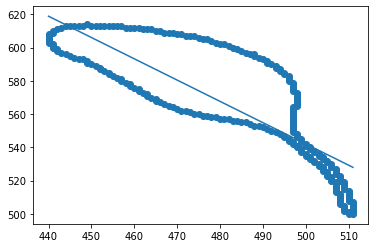

In [34]:
import matplotlib.pyplot as plt
from scipy import stats

x = ctr_in_px[:, 0]
y = ctr_in_px[:, 1]

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
x_line = np.linspace(x.min(), x.max(), 10)
y_line = x_line * slope + intercept

plt.scatter(x, y)
plt.plot(x_line, y_line)

### Merge data in HDF5 file

In [35]:
session_path = save_to
#session_path = os.path.join('sessions', '2021-07-30_09-24-14')  # some particular session

In [36]:
if not trial > 0:
    raise SystemExit('Nothing recorded. No sense to continue.')

# do pack data to HDF5
h5name = pack(session_path)

ValueError: could not convert string to float: 'None'

### Plot sessions stats

In [ ]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
from scipy import signal

In [ ]:
arena_r = 0.4  # in meters

with h5py.File(h5name, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    trial_idxs = np.array(f['processed']['trial_idxs'])

In [ ]:
fig = plt.figure(figsize=(12, 12))

# trajectory and islands
ax = fig.add_subplot(221)
ax.scatter(tl[:, 1], tl[:, 2], s=1, alpha=0.1)  # positions
scat = ax.scatter(trial_idxs[:, 2], trial_idxs[:, 3], s=1000, facecolors='none', edgecolors='r')  # islands, radius approx.
ax.add_patch(plt.Circle((0, 0), arena_r, color='r', fill=False))
ax.set_aspect('equal')
ax.set_xlabel('X, m', fontsize=14)
ax.set_ylabel('Y, m', fontsize=14)
ax.set_title('Running', fontsize=14)
ax.grid()

# occupancy
sigma = 0.1
lin_profile = np.linspace(-15, 15, 20)
bump = np.exp(-sigma * lin_profile**2)
bump /= np.trapz(bump)  # normalize to 1
kernel = bump[:, np.newaxis] * bump[np.newaxis, :]
occupancy_map, _, _ = np.histogram2d(tl[:, 1], tl[:, 2], bins=[40, 40], range=np.array([[-0.5, 0.5], [-0.5, 0.5]]))
occupancy_map = signal.convolve2d(occupancy_map, kernel, mode='same')

ax = fig.add_subplot(222)
ax.imshow(occupancy_map, origin='lower', extent=(-0.5, 0.5, -0.5, 0.5), cmap='Blues')
ax.add_patch(plt.Circle((0, 0), arena_r, color='r', fill=False))
ax.set_xlabel('X, m', fontsize=14)
ax.set_title('Occupancy', fontsize=14)
ax.grid()

# trials
durations = tl[trial_idxs[:, 1].astype(int)][:, 0] - tl[trial_idxs[:, 0].astype(int)][:, 0]
colors = ['red' if x == 1 else 'grey' for x in trial_idxs[:, 5]]

ax = fig.add_subplot(223)
ax.barh(np.arange(len(trial_idxs)), durations, color=colors, align='center')
ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('Trial, #', fontsize=14)
ax.set_title('Trials', fontsize=14)

# speed
ax = fig.add_subplot(224)
ax.hist(tl[:, 3], bins=50, ec='black')
ax.set_xlabel('Speed, m/s', fontsize=14)
ax.set_title('Speed', fontsize=14)